In [81]:
"""
Copyright 2022 Huawei Technologies Co., Ltd

CREATED:  2020-6-04 20:12:13
MODIFIED: 2022-02-10 01:48:45
"""
# -*- coding:utf-8 -*-
import cv2

from time import sleep
from uuid import uuid4
from base64 import b64encode
from json import dumps, loads
from redis import StrictRedis
from PIL import Image, ImageDraw
from utils.preprocessing import preprocess
from IPython.lib.backgroundjobs import BackgroundJobFunc

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 ### First of all, please run `pyacl_app.py` script!

In [83]:
# connect to Redis server
redis_db = StrictRedis(host='localhost',port=6379, db=0)

In [84]:
# deserialize the text-detection model output info
q_model_input_dims = loads(redis_db.lrange('model_input_dims', 0, 2)[0].decode("utf-8"))

In [85]:
with open("data/coco.names") as fd:
    coco_labels = fd.readlines()

coco_labels = [i[:-1] for i in coco_labels][0:]

In [86]:
img_path = "data/images/person.jpg"
img_rgb = cv2.imread(img_path)[:,:,::-1]

In [100]:
%timeit -n 10 -r 2 

# convert img to data
img_data = preprocess(img_rgb, (q_model_input_dims['w'], q_model_input_dims['h']))
        
# ensure our NumPy array is C-contiguous as well,
# otherwise we won't be able to serialize it
img_data = img_data.copy(order="C")
        
# generate an ID for the classification then add the
# classification ID + image to the queue
k = str(uuid4())
img_data_dims = img_data.shape
img_data = b64encode(img_data).decode("utf-8")
d = {"id": k, "img": img_data, "img_dims" : img_rgb.shape, 
    "img_np_dims" : img_data_dims}
redis_db.rpush('model_img_queue', dumps(d))
        
# keep looping until our model server returns the output
# predictions
bboxes = ""
while True:
    # attempt to grab the output predictions
    output = redis_db.get(k)
            
    # check to see if our model has classified the input
    # image
    if output is not None:
        # add the output predictions to our data
        # dictionary so we can return it to the client
        output = output.decode("utf-8")
        bboxes = loads(output)
                
        # delete the result from the database and break
        # from the polling loop
        redis_db.delete(k)
        break
                
    # sleep for a small amount to give the model a chance
    # to classify the input image
    sleep(0.15)

bboxes = loads(bboxes['bboxes'])

[PreProc] img_resize shape: (3, 640, 640)
[PreProc] img_np shape: (1, 12, 320, 320)


In [101]:
pil_img = Image.fromarray(img_rgb)

In [102]:
img1 = ImageDraw.Draw(pil_img)
for bbox in bboxes:
    img1.rectangle(list(tuple(bbox[:4])), outline ="red", width=2)
    print(bbox[:4], bbox[4], bbox[5], coco_labels[int(bbox[5])])

[190.0, 96.0, 274.0, 378.0] 0.92354923 0 person
[64.0, 265.0, 206.0, 349.0] 0.905717 16 dog
[405.0, 138.0, 600.0, 352.0] 0.88476676 17 horse


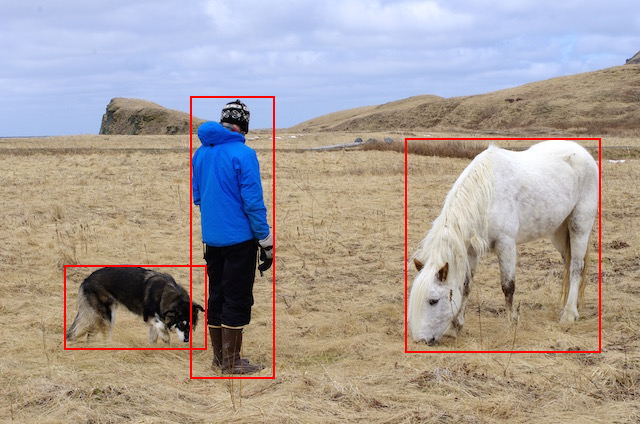

In [103]:
pil_img